In [ ]:
!pip install tensorflow

### **Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Feb  9 16:17:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Utility Functions**

In [ ]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    MAX_FILE_COUNT = 250
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    # file_list.count
    cnt = 0
    for file in file_list:
        cnt += 1
        if cnt > MAX_FILE_COUNT: #Stop creating files in the local directory if the number of files > MAX_FILE_COUNT
          break
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass

def get_mismatches(y_true, y_pred, BATCH_SIZE):
    num_mismatches = 0
    mismatch_tensor_indexes = {}
    for i in range(len(y_true)):
      if y_true[i] != y_pred[i]:
        num_mismatches += 1
        key = (i//BATCH_SIZE)
        tensor_index = (i % BATCH_SIZE)
        if mismatch_tensor_indexes.get(key) is not None:
          mismatch_tensor_indexes[key].append((tensor_index, i))
        else:
          mismatch_tensor_indexes[key] = [(tensor_index, i)]
    return num_mismatches, mismatch_tensor_indexes

def show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches):
    i=0
    total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
    tensor_batch = 0
    plt.figure(figsize=(15, (math.ceil(num_mismatches/30)*20)))
    for images, labels in test_ds.take(total_tensor_batches):
      if mismatch_tensor_indexes.get(tensor_batch) is not None:
        for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
          ax = plt.subplot(math.ceil(num_mismatches/4), 4, i + 1)
          plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1
      tensor_batch += 1

##**Step 0: If you have already created the Train, Validation and Test datasets and stored it in GDrive then you can skip Steps 1 and 2 (otherwise skip Step 0 and go to Step 1)**

In [ ]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1HPhX4Pk72yYeqB1l3NK46d69GblH4EkE'
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = ''

root = './data/processed/schuhe'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

if not os.path.isdir("./data/processed/schuhe"):
  os.mkdir('./data/processed/schuhe')

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()

Creating folder: ./data/processed/schuhe/train_dataset
Creating folder: ./data/processed/schuhe/train_dataset/16987983935898993072
Creating folder: ./data/processed/schuhe/train_dataset/16987983935898993072/00000000.shard
Creating folder: ./data/processed/schuhe/val_dataset
Creating folder: ./data/processed/schuhe/val_dataset/16589395308831395301
Creating folder: ./data/processed/schuhe/val_dataset/16589395308831395301/00000000.shard
Creating folder: ./data/processed/schuhe/test_dataset
Creating folder: ./data/processed/schuhe/test_dataset/14676325214951781202
Creating folder: ./data/processed/schuhe/test_dataset/14676325214951781202/00000000.shard


In [ ]:
PRODUCT_CATEGORY = 'schuhe'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_SIZE = (427, 350)
#IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

CLASSES = ['schuhe_0_overall_to_right'
           , 'schuhe_1_back'
           , 'schuhe_2_top_or_soul'
           , 'schuhe_3_side_to_left'
           , 'schuhe_4_zoom'
           ]

train_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')


In [ ]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.json with shape {}'.format(json_path, tdf.shape))
  return tdf

In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
schuhe_0_overall_to_right occurs 155 times
schuhe_1_back occurs 166 times
schuhe_2_top_or_soul occurs 154 times
schuhe_3_side_to_left occurs 159 times
schuhe_4_zoom occurs 134 times


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
schuhe_0_overall_to_right occurs 44 times
schuhe_1_back occurs 44 times
schuhe_2_top_or_soul occurs 54 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 69 times


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
schuhe_0_overall_to_right occurs 49 times
schuhe_1_back occurs 35 times
schuhe_2_top_or_soul occurs 46 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 51 times


In [ ]:
train_classes, train_class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)

val_classes, val_class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)

test_classes, test_class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)

# Print summary table
print("| Class                          | Train | Validation | Test |")
print("|------------------------------  |-------|------------|------|")
for class_id in range(len(train_classes)):
    class_name = CLASSES[train_classes[class_id]]
    train_count = train_class_count[class_id]
    val_count = val_class_count[class_id]
    test_count = test_class_count[class_id]
    print(f"| {class_name:<30} | {train_count:<5} | {val_count:<10} | {test_count:<4} |")

| Class                          | Train | Validation | Test |
|------------------------------  |-------|------------|------|
| schuhe_0_overall_to_right      | 155   | 44         | 49   |
| schuhe_1_back                  | 166   | 44         | 35   |
| schuhe_2_top_or_soul           | 154   | 54         | 46   |
| schuhe_3_side_to_left          | 159   | 45         | 45   |
| schuhe_4_zoom                  | 134   | 69         | 51   |


#### Visualize the data

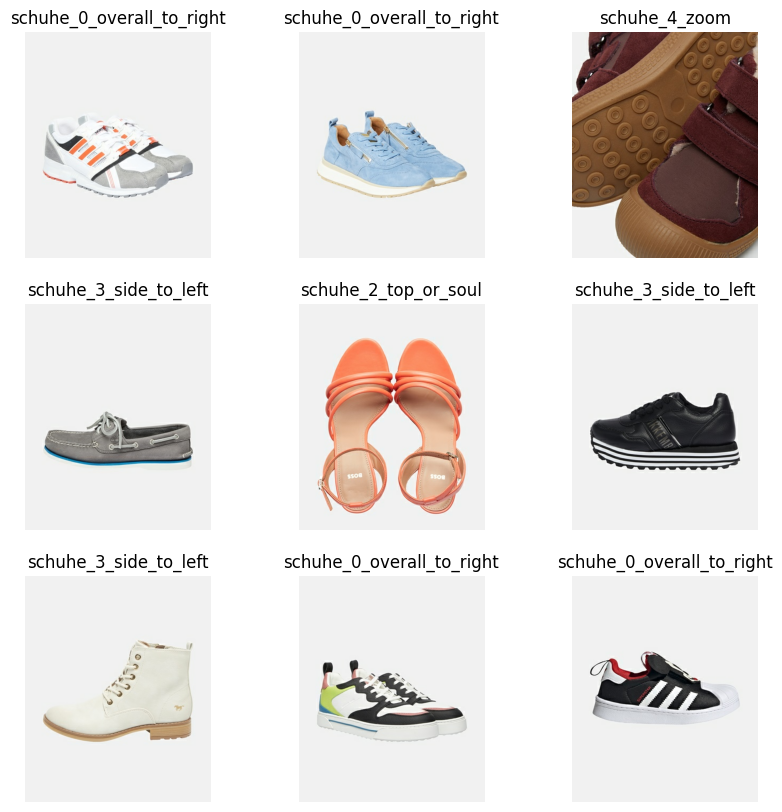

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

## **Step 1: Importing the Image data from Google drive**
see other notebooks..

##**Step 2: Load image data and split them into Train, Validation and Test**
see other notebooks..

## **Step 3: Create and train the EfficientNet model**


In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn
from keras.applications import EfficientNetB0

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D

In [ ]:
PRODUCT_CATEGORY = 'schuhe'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_SIZE = (427, 350)
BATCH_SIZE = 32
CLASSES = ['schuhe_0_overall_to_right'
           , 'schuhe_1_back'
           , 'schuhe_2_top_or_soul'
           , 'schuhe_3_side_to_left'
           , 'schuhe_4_zoom'
           ]

train_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

##### Print the shapes of the image and label batches

In [ ]:
# Define the number of classes
num_classes = len(CLASSES)
IMG_SHAPE = (224, 224, 3)

print(BATCH_SIZE)
print(IMG_SIZE)
print(num_classes)

32
(427, 350)
5


#### Resize images

In [ ]:
# Set the image size and batch size
IMG_SIZE = (427, 350)
target_size = (224, 224)
batch_size = 32

def resize_images_and_labels(image, label):
    # Resize images
    image = tf.image.resize(image, target_size)
    # Return resized images and original labels
    return image, label

# Apply resizing to train_ds, val_ds, and test_ds
train_ds_resized = train_ds.map(resize_images_and_labels)
val_ds_resized = val_ds.map(resize_images_and_labels)
test_ds_resized = test_ds.map(resize_images_and_labels)

In [ ]:
for image_batch, labels_batch in train_ds_resized:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


Improve the data pipeline’s performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_da_resized = train_ds_resized.prefetch(buffer_size=AUTOTUNE)
val_ds_resized = val_ds_resized.prefetch(buffer_size=AUTOTUNE)
test_ds_resized = test_ds_resized.prefetch(buffer_size=AUTOTUNE)

#### Create the base model

In [ ]:
img_shape = target_size + (3,)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet',
                            include_top=False,
                            input_shape=img_shape)

##### Feature extraction

In [ ]:
input_shape = base_model.input_shape
output_shape = base_model.output_shape

print(input_shape)
print(output_shape)

(None, 224, 224, 3)
(None, 7, 7, 1280)


In [ ]:
# print feature batch shape
image_batch, label_batch = next(iter(train_ds_resized))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2

### Create a new model on top
After creating the base model, you can build the custom head on top of it to perform the specific classification task you need. This is typically done by adding some additional layers like Global Average Pooling, Dropout, and Dense layers, followed by a final classification layer with the desired number of output classes. By doing so, you can leverage the pre-trained feature extractor (EfficientNetB0) and fine-tune it for your specific problem.

In [ ]:
#Freeze the convolutional base
base_model.trainable = False

#### Add custom layers
Let’s create a new transfer learning model by adding custom layers on top of the pre-trained EfficientNetB0 base model, including global average pooling2D layer, and dense layers.

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#### Compile and train the model
After creating the transfer learning model, you can compile it using the compile method and then train it using the training data (train_dataset) and validation data (val_dataset) generated earlier.
Don’t forget to use appropriate loss functions and metrics for your specific classification task. Here, we used sparse_categorical_crossentropy function because we use label_mode='int'(the labels are encoded as integers) when generating the dataset.

In [ ]:
base_learning_rate = 0.0001

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Display the numers of trainable varaibles
len(model.trainable_variables)

4

##### Train the model

In [ ]:
initial_epochs = 40

# Train the model for initial training
history_initial = model.fit(train_ds_resized,
                            epochs=initial_epochs,
                            validation_data=val_ds_resized,
                            )

Epoch 1/40
24/24 [==============================] - 13s 172ms/step - loss: 1.3980 - accuracy: 0.4922 - val_loss: 1.2254 - val_accuracy: 0.6172
Epoch 2/40
24/24 [==============================] - 6s 258ms/step - loss: 1.0139 - accuracy: 0.7786 - val_loss: 0.9390 - val_accuracy: 0.7891
Epoch 3/40
24/24 [==============================] - 5s 206ms/step - loss: 0.7777 - accuracy: 0.8477 - val_loss: 0.7487 - val_accuracy: 0.8281
Epoch 4/40
24/24 [==============================] - 6s 238ms/step - loss: 0.6262 - accuracy: 0.8698 - val_loss: 0.6311 - val_accuracy: 0.8516
Epoch 5/40
24/24 [==============================] - 4s 146ms/step - loss: 0.5295 - accuracy: 0.8776 - val_loss: 0.5543 - val_accuracy: 0.8672
Epoch 6/40
24/24 [==============================] - 4s 174ms/step - loss: 0.4679 - accuracy: 0.8828 - val_loss: 0.5007 - val_accuracy: 0.8867
Epoch 7/40
24/24 [==============================] - 5s 213ms/step - loss: 0.4167 - accuracy: 0.8958 - val_loss: 0.4629 - val_accuracy: 0.8906
Epoch

In [ ]:
y_true, y_pred = eval_model_on_test(model, test_ds_resized)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:02<00:14,  2.08s/it]

1/1 [==============================] - 0s 35ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:02<00:05,  1.02it/s]

1/1 [==============================] - 0s 62ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.55it/s]

1/1 [==============================] - 0s 58ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:01,  2.08it/s]

1/1 [==============================] - 0s 61ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  2.55it/s]

1/1 [==============================] - 0s 54ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.96it/s]

1/1 [==============================] - 0s 95ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  3.36it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


In [ ]:
print("Accuracy of EffiecentB0 on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of EffiecentB0 on test data: 92.48%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.88      0.88      0.88        49
            schuhe_1_back       0.94      0.97      0.96        35
     schuhe_2_top_or_soul       0.98      0.96      0.97        46
    schuhe_3_side_to_left       0.84      0.91      0.87        45
            schuhe_4_zoom       1.00      0.92      0.96        51

                 accuracy                           0.92       226
                macro avg       0.93      0.93      0.93       226
             weighted avg       0.93      0.92      0.93       226



,0,1,2,3,4
0,43,2,0,4,0
1,1,34,0,0,0
2,0,0,44,2,0
3,3,0,1,41,0
4,2,0,0,2,47


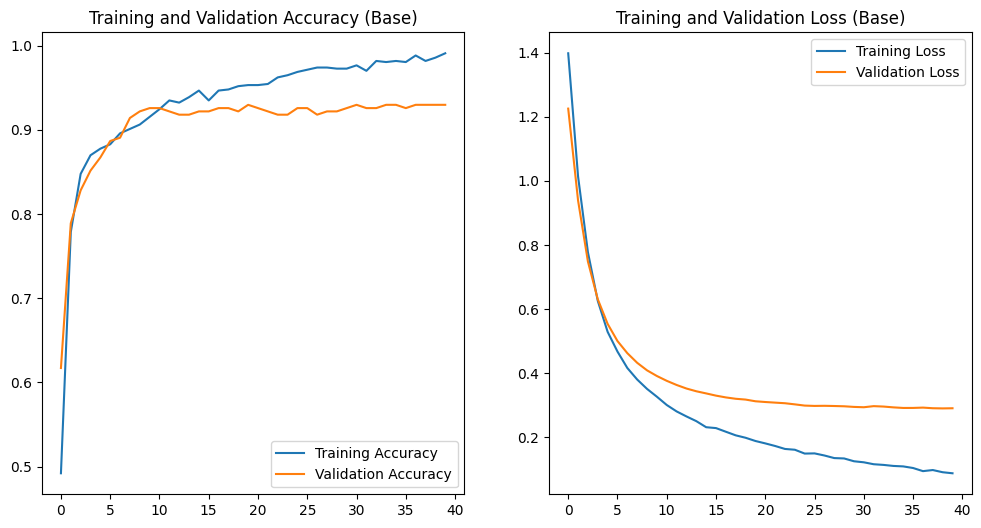

In [ ]:
plot_accuracy_loss(history_initial)

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_model_EffB0.h5", save_best_only=True)

history_initial = model.fit(
                                        x=train_ds_resized,
                                        batch_size=BATCH_SIZE,
                                        epochs=initial_epochs,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds_resized)

Epoch 1/40
24/24 [==============================] - 6s 237ms/step - loss: 0.0901 - accuracy: 0.9805 - val_loss: 0.2900 - val_accuracy: 0.9297
Epoch 2/40
24/24 [==============================] - 4s 171ms/step - loss: 0.0868 - accuracy: 0.9883 - val_loss: 0.2898 - val_accuracy: 0.9297
Epoch 3/40
24/24 [==============================] - 6s 249ms/step - loss: 0.0848 - accuracy: 0.9870 - val_loss: 0.2900 - val_accuracy: 0.9297
Epoch 4/40
24/24 [==============================] - 5s 204ms/step - loss: 0.0828 - accuracy: 0.9857 - val_loss: 0.2914 - val_accuracy: 0.9297
Epoch 5/40
24/24 [==============================] - 5s 228ms/step - loss: 0.0803 - accuracy: 0.9844 - val_loss: 0.2903 - val_accuracy: 0.9297
Epoch 6/40
24/24 [==============================] - 5s 221ms/step - loss: 0.0774 - accuracy: 0.9883 - val_loss: 0.2895 - val_accuracy: 0.9297
Epoch 7/40
24/24 [==============================] - 7s 297ms/step - loss: 0.0729 - accuracy: 0.9883 - val_loss: 0.2929 - val_accuracy: 0.9297
Epoch 

## ** ## Transfer learning Fine tuning**

**Unfreeze the base_model**

In [ ]:
#Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  238


The base_model is unfrozen, and fine-tuning is performed on a subset of the layers starting from a specific layer index (fine_tune_at).

In [ ]:
# Unfreeze the base_model.

base_model.trainable = True

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-200:]:
     layer.trainable = True,

Recompile the model

In [ ]:
# Recompile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Continue training the model

In [ ]:
# Set batch size and number of epochs for fine-tuning
epochs_fine_tuning = 20

 # Define callbacks for early stopping and model checkpoint to save the best model

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_model_EffB0_ft.h5",
                                              save_best_only=True,
                                                monitor='val_accuracy', verbose=1,
                                                mode='max')

total_epochs =  initial_epochs + epochs_fine_tuning

history_fine_tuning = model.fit(train_ds_resized,
                                         initial_epoch = history_initial.epoch[-1],
                                         epochs = epochs_fine_tuning,
                                        verbose="auto",
                                       callbacks=[early_stopping_cb, checkpoint_cb],
                                       validation_data=val_ds_resized)

Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 11: val_accuracy improved from -inf to 0.92969, saving model to schuhe_model_EffB0_ft.h5
24/24 [==============================] - 9s 368ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3253 - val_accuracy: 0.9297
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.92969
24/24 [==============================] - 8s 315ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3301 - val_accuracy: 0.9297
Epoch 13/20
24/24 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 13: val_accuracy did not improve from 0.92969
24/24 [==============================] - 9s 381ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3419 - val_accuracy: 0.9297
Epoch 14/20
24/24 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000
Epoch 14: val_accuracy did n

In [ ]:
y_true, y_pred = eval_model_on_test(model, test_ds_resized)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:39<04:39, 39.90s/it]

1/1 [==============================] - 0s 40ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:40<01:39, 16.52s/it]

1/1 [==============================] - 0s 35ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:40<00:45,  9.08s/it]

1/1 [==============================] - 0s 35ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:40<00:22,  5.55s/it]

1/1 [==============================] - 0s 35ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:40<00:10,  3.63s/it]

1/1 [==============================] - 0s 40ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:40<00:04,  2.47s/it]

1/1 [==============================] - 0s 45ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:40<00:01,  1.71s/it]

1/1 [==============================] - 0s 32ms/step


Predicting on Test Data: 100%|██████████| 8/8 [01:21<00:00, 10.24s/it]


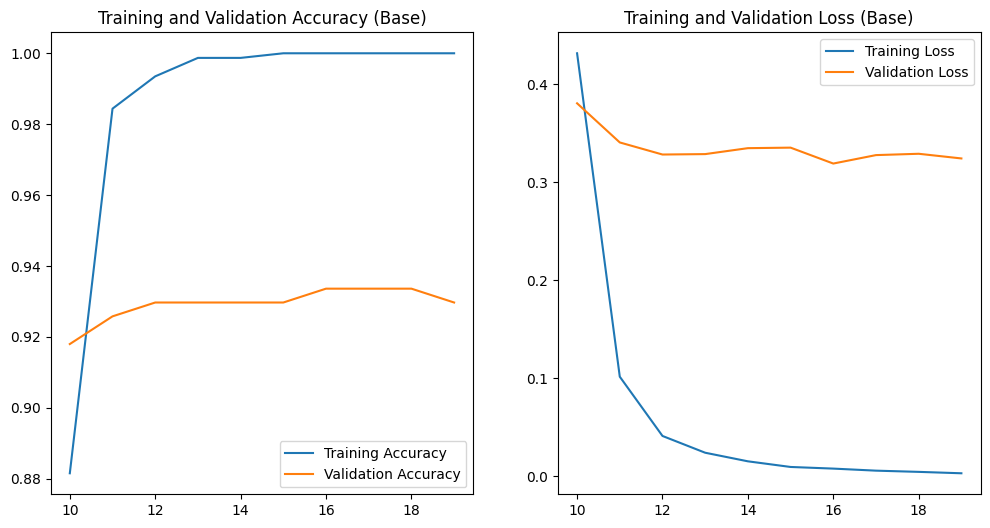

In [ ]:
plot_accuracy_loss(history_fine_tuning)

In [ ]:
print("Accuracy of EffiecentB0_ft on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of EffiecentB0_ft on test data: 96.02%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.96      0.98      0.97        49
            schuhe_1_back       1.00      0.97      0.99        35
     schuhe_2_top_or_soul       0.98      0.96      0.97        46
    schuhe_3_side_to_left       0.88      0.96      0.91        45
            schuhe_4_zoom       1.00      0.94      0.97        51

                 accuracy                           0.96       226
                macro avg       0.96      0.96      0.96       226
             weighted avg       0.96      0.96      0.96       226



,0,1,2,3,4
0,48,0,0,1,0
1,1,34,0,0,0
2,0,0,44,2,0
3,1,0,1,43,0
4,0,0,0,3,48


Get mismatches

In [ ]:
def get_mismatches():
  num_mismatches = 0
  mismatch_tensor_indexes = {}
  for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
      num_mismatches += 1
      key = ((i+1)//BATCH_SIZE)
      tensor_index = (i % BATCH_SIZE)
      if mismatch_tensor_indexes.get(key) is not None:
        mismatch_tensor_indexes[key].append((tensor_index, i))
      else:
        mismatch_tensor_indexes[key] = [(tensor_index, i)]
  return num_mismatches, mismatch_tensor_indexes

In [ ]:
num_mismatches, mismatch_tensor_indexes = get_mismatches()
print(f"Number of mismatches = {num_mismatches}")
mismatch_tensor_indexes

Number of mismatches = 9


{0: [(1, 1), (17, 17)],
 1: [(14, 46), (17, 49)],
 2: [(5, 69)],
 3: [(23, 119)],
 5: [(20, 180)],
 6: [(31, 191), (14, 206)]}

In [ ]:
print(f'Test data image count = {len(y_true)}\n') # Returned from eval_model_on_test(model_base, test_ds) function

i=0
for images, labels in test_ds.take(8):
  print(i, len(labels))
  print(labels)
  i += 1

# With 247 images in test and batch size of 32, the last tensor labels should only have 23 labels (i.e. 7*32 + 23 = 247)
# Why do we have 32 labels in the last Tensor??? That would mean we have 8*32 = 256 images which is not the case!!!

Test data image count = 226

0 32
tf.Tensor([4 0 4 2 2 4 2 1 0 0 3 3 4 0 4 3 0 1 4 2 2 2 1 0 4 2 3 4 4 4 3 3], shape=(32,), dtype=int32)
1 32
tf.Tensor([0 0 4 3 2 3 3 0 0 3 1 1 4 2 2 3 0 3 0 3 0 2 1 4 4 2 3 4 0 3 0 0], shape=(32,), dtype=int32)
2 32
tf.Tensor([2 3 4 3 0 2 0 0 1 3 2 2 1 2 1 4 0 1 4 1 2 3 1 1 2 0 1 1 1 4 0 3], shape=(32,), dtype=int32)
3 32
tf.Tensor([1 3 2 3 1 2 4 2 3 3 2 1 0 2 0 0 0 0 2 3 1 1 2 4 2 1 3 2 2 3 3 3], shape=(32,), dtype=int32)
4 32
tf.Tensor([4 3 4 1 4 0 3 0 2 1 2 3 4 0 4 0 4 0 3 4 2 3 3 1 4 0 1 0 1 1 3 4], shape=(32,), dtype=int32)
5 32
tf.Tensor([0 2 0 4 4 0 0 1 0 4 4 4 2 0 4 4 2 0 4 1 4 4 4 0 1 1 0 4 3 0 4 3], shape=(32,), dtype=int32)
6 32
tf.Tensor([0 3 2 2 0 4 3 2 2 2 2 4 4 2 4 3 4 2 0 3 0 3 4 1 3 1 2 4 2 3 4 1], shape=(32,), dtype=int32)
7 2
tf.Tensor([0 2], shape=(2,), dtype=int32)


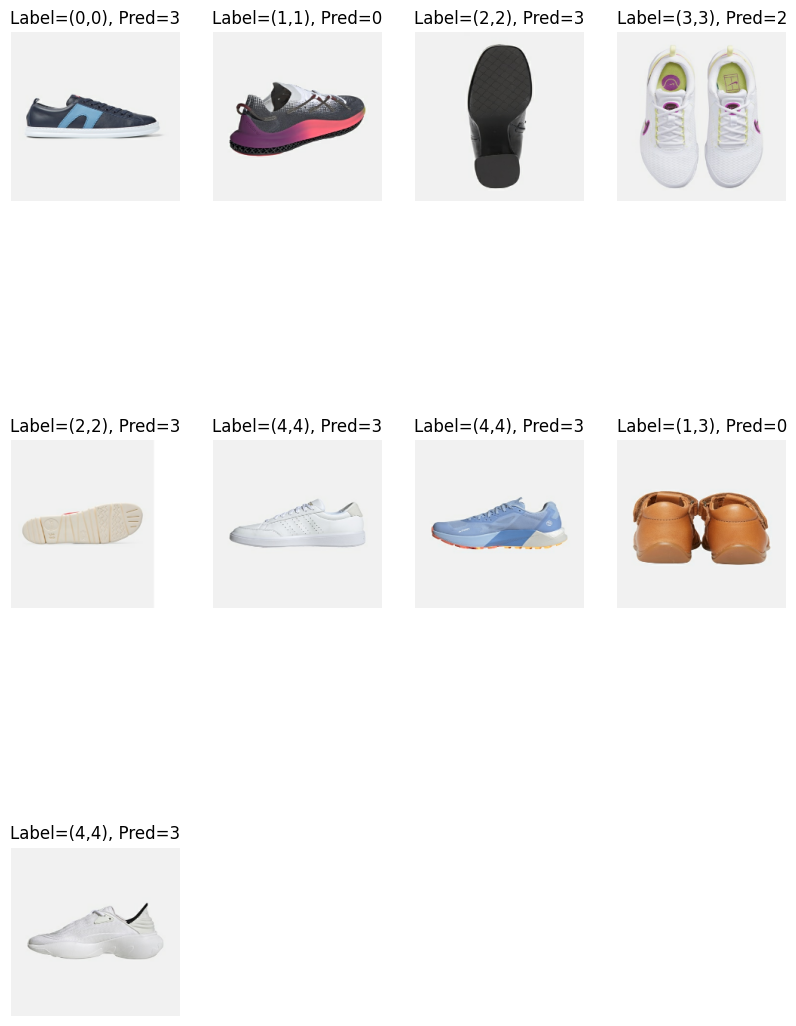

In [ ]:
import math
i=0
total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
tensor_batch = 0
plt.figure(figsize=(10, 15))
for images, labels in test_ds_resized.take(total_tensor_batches):
  if mismatch_tensor_indexes.get(tensor_batch) is not None:
    for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
      ax = plt.subplot(math.ceil(num_mismatches/4), 4, i+1)
      plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
      plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
      plt.axis("off")
      i += 1
  tensor_batch += 1

plt.show()

In [ ]:
# import math
# i=0
# total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
# plt.figure(figsize=(15, 200))
# for images, labels in test_ds.take(total_tensor_batches):
#   for j in range(len(labels)):
#     # print(f'{i}, {j}')
#     ax = plt.subplot(math.ceil(len(y_pred)/5), 5, i + 1)
#     plt.imshow(images[j].numpy().astype("uint8"))
#     plt.title(f"Label={labels[j]}, Pred={y_pred[i]}")
#     plt.axis("off")
#     i += 1

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
## Tips for fine tuning EfficientNet
On unfreezing layers:

The BatchNormalization layers need to be kept frozen (more details). If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy.
In some cases it may be beneficial to open up only a portion of layers instead of unfreezing all. This will make fine tuning much faster when going to larger models like B7.
Each block needs to be all turned on or off. This is because the architecture includes a shortcut from the first layer to the last layer for each block. Not respecting blocks also significantly harms the final performance.
Some other tips for utilizing EfficientNet:

Larger variants of EfficientNet do not guarantee improved performance, especially for tasks with less data or fewer classes. In such a case, the larger variant of EfficientNet chosen, the harder it is to tune hyperparameters.
EMA (Exponential Moving Average) is very helpful in training EfficientNet from scratch, but not so much for transfer learning.
Do not use the RMSprop setup as in the original paper for transfer learning. The momentum and learning rate are too high for transfer learning. It will easily corrupt the pretrained weight and blow up the loss. A quick check is to see if loss (as categorical cross entropy) is getting significantly larger than log(NUM_CLASSES) after the same epoch. If so, the initial learning rate/momentum is too high.
Smaller batch size benefit validation accuracy, possibly due to effectively providing regularization.